# Explaining TabPFN

TabPFN is a foundation model for tabular data, which uses in-context learning to do solve classification and regression tasks.
TabPFN outperforms traditional models like Random Forest, Gradient Boosting for small datasets and raises the state-of-the-art for tabular data!
Recently, a major update was released, which includes a new architecture and an updated API.

For more information about TabPFN, check the [github repository](https://github.com/PriorLabs/TabPFN) and the associated papers ([TabPFN](https://openreview.net/forum?id=eu9fVjVasr4), [TabPFNv2](https://www.nature.com/articles/s41586-024-08328-6)).

In this tutorial, we see how we can **use shapiq to explain the predictions of TabPFNv2**. 
We will use the California housing dataset and train a TabPFN model to predict the house prices.
Many explanation methods show that models tend to learn interactions between the latitude and longitude features, containing information about the exact location of a house.
We want to see if TabPFN also learns the interactions between latitude and longitude.

First, lets import the libraries (tabpfn and shapiq) and check their versions.
Note that this tutorial uses the latest version of TabPFN (> 2.0.0) and will not necessarily work with older versions.

In [39]:
from importlib.metadata import version

import shapiq
import tabpfn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("shapiq version: ", shapiq.__version__, "tabpfn version: ", version("tabpfn"))
print("Device: ", device)

shapiq version:  1.1.1 tabpfn version:  2.0.0
Device:  cpu


### Get the California Housing Data
Now let's load the California housing dataset and inspect the data.

In [29]:
x_data, y_data = shapiq.datasets.load_california_housing()
feature_names = x_data.columns

# copy the data to make sure we don't modify the original data
dataset = x_data.copy()
dataset["HousePrice"] = y_data
display(dataset.head())
display(dataset["HousePrice"].describe())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HousePrice
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: HousePrice, dtype: float64

Now we have loaded the data.
**HousePrice** is the target variable we want to predict.
The target ranges from 0.15 to 5.0.

In order to use TabPFN, we need to split the data into a training and testing set.
Note, that TabPFN works best for **small sized datasets** (less than 10k samples).
So let's select a train set of 10k samples.

In [30]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x_data.values, y_data.values, train_size=300, random_state=1
)
print("Train data shape: ", x_train.shape, y_train.shape)
print("Test data shape: ", x_test.shape, y_test.shape)

Train data shape:  (300, 8) (300,)
Test data shape:  (20340, 8) (20340,)


### Fit TabPFN
Now that we have the data, we can fit TabPFN to the training data and make it ready for predictions.

In [31]:
model = tabpfn.TabPFNRegressor(n_estimators=4, n_jobs=4, device="cuda")
model.fit(x_train, y_train)

TabPFNRegressor(n_estimators=4, n_jobs=4)

When we have the "trained" model, we can use it to predict the house prices.
These predictions are very competitive with the state-of-the-art models.

In [32]:
predictions = model.predict(x_test[:2000])

In [33]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mse = mean_squared_error(y_test[:2000], predictions)
r2 = r2_score(y_test[:2000], predictions)
print("MSE: ", mse, "R2: ", r2)

average_prediction = np.mean(predictions)
print("Average prediction: ", average_prediction)

MSE:  0.32530222052366137 R2:  0.753441412304244
Average prediction:  2.0711837


# Explain TabPFN with shapiq
Now that we see how TabPFN performs, we can use shapiq to explain the predictions.

In [34]:
# explainer = shapiq.Explainer(model, data=x_test[:1000], index="FSII", max_order=2, imputer="baseline")
# explainer._imputer.verbose = True
#
# x_explain = x_test[0]
#
# sv = explainer.explain(x_explain)
# sv.plot_force(feature_names=feature_names)

# Explaining TabPFN with Remove-and-"Retrain"

Since TabPFN is a foundation model, it uses in-context learning to solve the classification and regression tasks.
This means that "retraining" the model is quite inexpensive, because we only need to provide the new data points with whatever features we want to remove.

In [35]:
x_explain = x_test[0]
y_explain = y_test[0]

prediction = model.predict(x_explain.reshape(1, -1))[0]
print("Prediction: ", prediction)
print("True value: ", y_explain)
print("Average prediction: ", average_prediction)

Prediction:  3.4585295 True value:  3.55 Average prediction:  2.0711837


In [36]:
class TabPFNGame(shapiq.Game):
    """The TabPFN Game class implementation a remove-and-"retrain" strategy to explain the predictions of TabPFN."""

    def __init__(self, model, x_train, y_train, x_explain, average_prediction):
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_explain = x_explain
        self.average_prediction = average_prediction

        print("Initializing TabPFN Game")
        print("Train data shape: ", x_train.shape, y_train.shape)
        print("Explain data shape: ", x_explain.shape)

        super().__init__(n_players=x_train.shape[1], normalization_value=self.average_prediction)

    def value_function(self, coalitions: np.ndarray) -> np.ndarray:
        """The value function performs the remove-and-"retrain" strategy for TabPFN."""
        output = np.zeros(len(coalitions), dtype=float)
        for i, coalition in enumerate(coalitions):
            if sum(coalition) == 0:
                output[i] = self.average_prediction
                continue
            x_train_coal = self.x_train[:, coalition]
            x_explain_coal = self.x_explain[coalition].reshape(1, -1)
            self.model.fit(x_train_coal, self.y_train)
            pred = float(self.model.predict(x_explain_coal)[0])
            output[i] = pred
        return output

In [38]:
game = TabPFNGame(model, x_train, y_train, x_explain, average_prediction)
game.verbose = True
game.precompute()
game.save_values("tabpfn_values.npz")

Initializing TabPFN Game
Train data shape:  (300, 8) (300,)
Explain data shape:  (8,)


Evaluating game:   0%|          | 0/256 [00:00<?, ? coalition/s]

In [40]:
approximator = shapiq.KernelSHAP(n=game.n_players, random_state=42)
sv = approximator.approximate(budget=2**game.n_players, game=game)

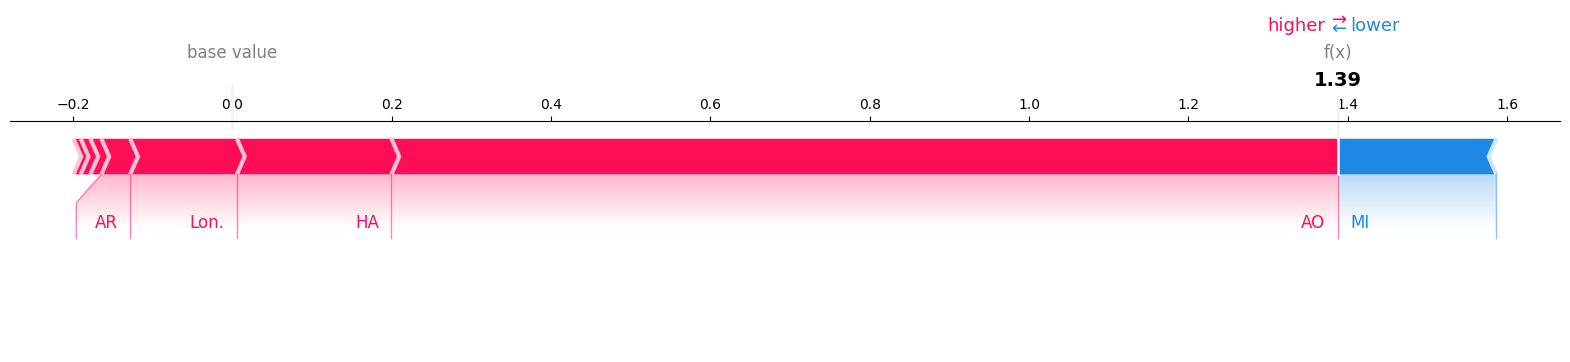

{(): 0.0,
 (0,): -0.19919682040048847,
 (1,): 0.1938878673232311,
 (2,): 0.03612450051107798,
 (3,): 0.012084188219684957,
 (4,): 0.009044129786639231,
 (5,): 1.1875691359177223,
 (6,): 0.013825137695848005,
 (7,): 0.1340076537387331}

In [41]:
sv.plot_force(feature_names=feature_names)
sv.dict_values